<a href="https://colab.research.google.com/github/Sravya106/ML-DL/blob/main/Malaria_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, InputLayer, AveragePooling2D, BatchNormalization, MaxPool2D, Dense, Flatten, Input, Layer, Dropout
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, activations
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet

**Data Preparation and Data Visualization**

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, shuffle_files= True, as_supervised=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [3]:
def split(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  length = len(dataset)
  train = dataset.take(int(TRAIN_RATIO*length))
  val_test = dataset.skip(int(TRAIN_RATIO*length))
  val = val_test.take(int(VAL_RATIO*length))
  test = val_test.skip(int(VAL_RATIO*length))
  return train, val, test

In [4]:
TRAIN_RATIO = 0.8
VAL_RATIO= 0.1
TEST_RATIO = 0.1

train_data, val_data, test_data = split(dataset[0], TRAIN_RATIO,VAL_RATIO,TEST_RATIO)

print(list(test_data.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]


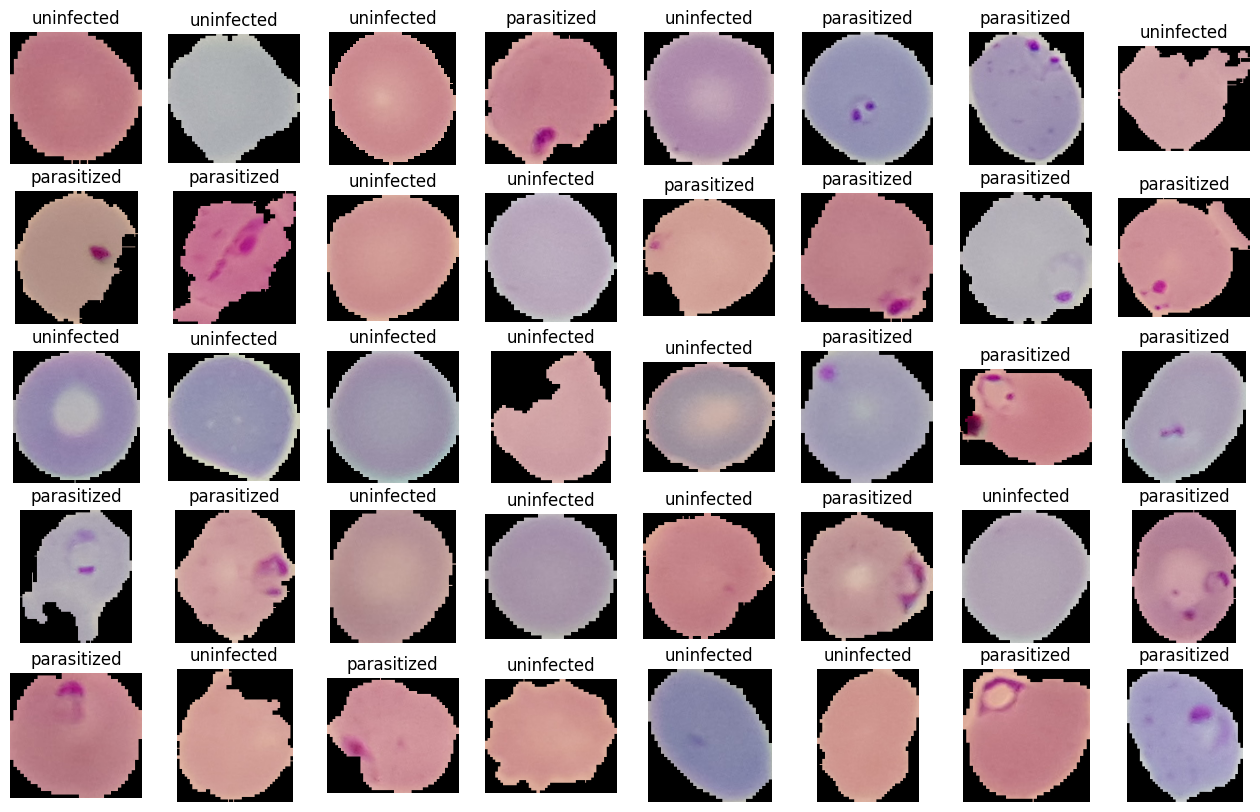

In [5]:
plt.figure(figsize=(16, 10))
for i,(image, label) in enumerate(train_data.take(40)):
  ax = plt.subplot(5,8 , i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

**Data Preprocessing** *'resizing all the images to 224px'*

In [6]:
IM_SIZE = 64
def resizing(image,label):
  return tf.image.resize(image,(IM_SIZE, IM_SIZE))/255.0, label

In [7]:

train_data = train_data.map(resizing)
val_data = val_data.map(resizing)
test_data = test_data.map(resizing)


In [8]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
train_data = (train_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

In [9]:
val_data = (val_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

In [10]:
test_data= (test_data.shuffle(buffer_size= 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE))

# **building model**  

#MobileNet API

In [47]:
mobilenet_model = MobileNet(input_shape=(64, 64, 3), include_top=False, weights=None)

model = models.Sequential([
    mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

#Training


In [54]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_64 (Functional)       │ (None, 2, 2, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,794,693 (48.81 MB)

 Trainable params: 4,257,601 (16.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 8,515,204 (32.48 MB)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=1,
                               mode='min',
                               verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 587s 838ms/step - accuracy: 0.8025 - loss: 0.9925 - val_accuracy: 0.4936 - val_loss: 3.4883
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 646s 873ms/step - accuracy: 0.9402 - loss: 0.1807 - val_accuracy: 0.9318 - val_loss: 0.1805
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 609s 855ms/step - accuracy: 0.9504 - loss: 0.1564 - val_accuracy: 0.9568 - val_loss: 0.1410
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 620s 852ms/step - accuracy: 0.9553 - loss: 0.1396 - val_accuracy: 0.9615 - val_loss: 0.1303
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 586s 850ms/step - accuracy: 0.9552 - loss: 0.1390 - val_accuracy: 0.9586 - val_loss: 0.1528
Epoch 5: early stopping


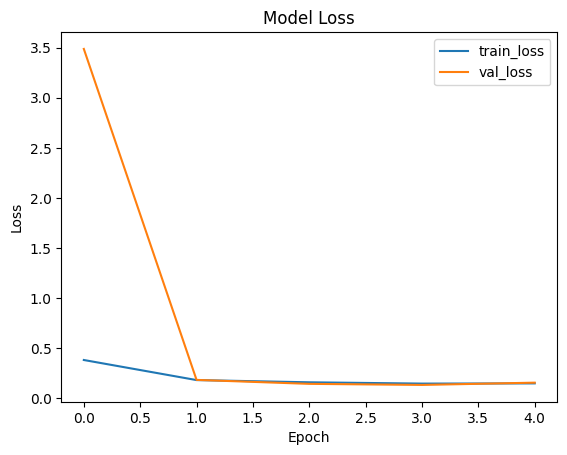

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# **Model Evaluation and Testing**

In [57]:
test_data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [58]:
train_data


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# val_data

In [59]:
model.evaluate(test_data)

87/87 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.9558 - loss: 0.1618


[0.16531594097614288, 0.9524846076965332]

In [60]:
y_true = test_data
y_pred = model.predict(test_data)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)


87/87 ━━━━━━━━━━━━━━━━━━━━ 30s 143ms/step


In [61]:
model.predict(test_data.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


0.93370587

In [62]:
def parasite_or_not(x):
  if (x<0.5):
    return str('p')
  else:
    return str('U')

In [63]:
parasite_or_not(model.predict(test_data.take(1))[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


'U'

This model may not be as accurate because the no.of epoches is set to 5 for saving time, in practiece no.of epoch is set 100 for better accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


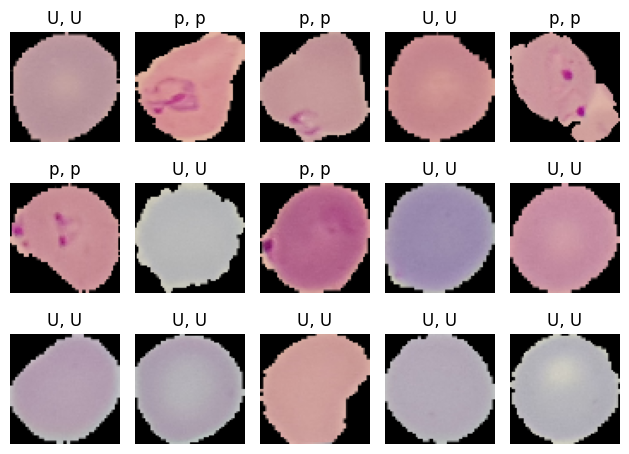

In [64]:
for i, (image, label) in enumerate(test_data.take(15)):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image[0].numpy())
    true_label = label.numpy()[0]
    predicted_prob = model.predict(image)
    predicted_label = int(predicted_prob[0][0] > 0.5)

    plt.title(f"{parasite_or_not(true_label)}, {parasite_or_not(predicted_label)}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Confusion Matrics

In [42]:
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [43]:
labels = []
inp = []
# for t in test_dataset:
#   print(t)
#   break
for x,y in test_data.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [45]:
labels = np.array([i[0] for i in labels])
print(labels)

[0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1
 0 0 1 0 1 0 0 0 1 0 0 1 1]
